### Moje narzędzia #2.4 - Feature Selection - Kwiecień 2020 [''Stroke_Prediction'']

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 

warnings.filterwarnings("ignore")

%matplotlib inline

df= pd.read_csv('/home/wojciech/Pulpit/1/Stroke_Prediction.csv')
print(df.shape)
print()
print(df.columns)
df.head(3)

(43400, 12)

Index(['ID', 'Gender', 'Age_In_Days', 'Hypertension', 'Heart_Disease',
       'Ever_Married', 'Type_Of_Work', 'Residence', 'Avg_Glucose', 'BMI',
       'Smoking_Status', 'Stroke'],
      dtype='object')


,ID,Gender,Age_In_Days,Hypertension,Heart_Disease,Ever_Married,Type_Of_Work,Residence,Avg_Glucose,BMI,Smoking_Status,Stroke
0,31153,Male,1104.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30650,Male,21204.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,17412,Female,2928.0,0,0,No,Private,Urban,110.89,17.6,NaN,0


### <span style="color:green"> Kasuje bezsensowne kolumny

In [2]:
# del df['Unnamed: 0']
# del df['Unnamed: 0.1']

### <span style="color:green"> Wielkość bazy df jest ogromna - wyciągam tylko 100% losowo wybranych rekordów</span> 
Taka metoda jest najbardziej reprezentatywna i oszczędza zasoby komputera.

In [5]:
df2 = df.sample(frac = 1.00, random_state=10)
df2.shape

(43400, 12)

## <span style="color:green"> Wyświetlenie braków </span>  (własnej roboty)

In [6]:
a,b = df2.shape     #<- ile mamy kolumn
b

print('NUMBER OF EMPTY RECORDS vs. FULL RECORDS')
print('----------------------------------------')
for i in range(1,b):
    i = df2.columns[i]
    r = df2[i].isnull().sum()
    h = df2[i].count()
    pr = (r/h)*100
   
    if r > 0:
        print(i,"--------",r,"--------",h,"--------",pr) 

NUMBER OF EMPTY RECORDS vs. FULL RECORDS
----------------------------------------
BMI -------- 1462 -------- 41938 -------- 3.4860985263961086
Smoking_Status -------- 13292 -------- 30108 -------- 44.14773482130995


## <span style="color:green"> Nie warto kasować rekordów z brakami tylko warto wstawiać tam wartości z poza zakresu </span>

Wyszukuje tylko puste rekordy

In [7]:
null_value_stats = df2.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

BMI                1462
Smoking_Status    13292
dtype: int64

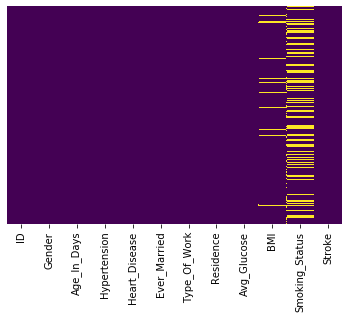

In [8]:
import seaborn as sns

sns.heatmap(df2.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Wstawia w puste miejsca wartości z poza zakresu

In [9]:
df2.fillna(7777, inplace=True)

## <span style="color:green"> Przegląd danych pod kontem formatu i ilości wartości unikalnych</span>  (własnej roboty)

In [10]:
a,b = df2.shape     #<- ile mamy kolumn
b

import numpy as np

for i in range(1,b):
    i = df2.columns[i]
    h = df2[i].nunique()
    f = df2[i].dtypes
          
    print(f,'---nunique->',h,'---name->', i)

object ---nunique-> 3 ---name-> Gender
float64 ---nunique-> 4848 ---name-> Age_In_Days
int64 ---nunique-> 2 ---name-> Hypertension
int64 ---nunique-> 2 ---name-> Heart_Disease
object ---nunique-> 2 ---name-> Ever_Married
object ---nunique-> 5 ---name-> Type_Of_Work
object ---nunique-> 2 ---name-> Residence
float64 ---nunique-> 12543 ---name-> Avg_Glucose
float64 ---nunique-> 556 ---name-> BMI
object ---nunique-> 4 ---name-> Smoking_Status
int64 ---nunique-> 2 ---name-> Stroke


## <span style="color:green"> Które z tych funkcji są kategoryczne?</span> (własnej roboty)

Stawiam dwa warunki: 

1. funkcja jest kategoryczna bo ma format 'object'
2. funkcja jest kategoryczna bo ma do 10 unikalnych wartości

In [11]:
a,b = df2.shape     #<- ile mamy kolumn
b

print('ONLY DISCRETE FUNCTION')
print('----------------------')
for i in range(1,b):
    i = df2.columns[i]
    f = df2[i].dtypes
    h = df2[i].nunique()
    
    if f == np.object or h<=10:
        print(i,"---",f,"---",h)

ONLY DISCRETE FUNCTION
----------------------
Gender --- object --- 3
Hypertension --- int64 --- 2
Heart_Disease --- int64 --- 2
Ever_Married --- object --- 2
Type_Of_Work --- object --- 5
Residence --- object --- 2
Smoking_Status --- object --- 4
Stroke --- int64 --- 2


#### Potrzebujemy listy z numerami kolumnaby użyć jej w CatBoost¶

In [12]:
import numpy as np
a,b = df2.shape     #<- ile mamy kolumn
b

print()
categorical_fun = np.where((df2.dtypes == np.object)|(df2.nunique() <= 15))[0]
x1 = len(categorical_fun)
print('categorical_fun: ',x1)
print('categorical_fun: ',categorical_fun)
print()
numerical_fun = np.where((df2.dtypes != np.object)&(df2.nunique() > 15))[0]
x2 = len(numerical_fun)
print('numerical_fun: ',x2)
print('numerical_fun: ',numerical_fun)
print()
print('LICZBA KOLUMN MA SIĘ ZGADZAĆ!')
print('all columns:                     ',b)
print('numerical_fun + categorical_fun: ',x1+x2)


categorical_fun:  8
categorical_fun:  [ 1  3  4  5  6  7 10 11]

numerical_fun:  4
numerical_fun:  [0 2 8 9]

LICZBA KOLUMN MA SIĘ ZGADZAĆ!
all columns:                      12
numerical_fun + categorical_fun:  12


## <span style="color:red"> Uwaga! 
#### <span style="color:red">    1. dane categorialne nie muszą mieć tylko formatu tekstowego, 

#### <span style="color:red">    2. dane tekstowe trzeba przerobić do formatu numerycznego 

### <span style="color:green"> Narzędzie do automatycznego kodowania zmiennych dyskretnych </span>(własnej roboty)


In [13]:
a,b = df2.shape     #<- ile mamy kolumn
b

print('DISCRETE FUNCTIONS CODED')
print('------------------------')
for i in range(1,b):
    i = df2.columns[i]
    f = df2[i].dtypes
    if f == np.object:
        print(i,"---",f)   
    
        if f == np.object:
        
            df2[i] = pd.Categorical(df2[i]).codes
        
            continue

DISCRETE FUNCTIONS CODED
------------------------
Gender --- object
Ever_Married --- object
Type_Of_Work --- object
Residence --- object
Smoking_Status --- object


### <span style="color:green"> Narzędzie do automatycznej zmiany znaku na plus </span>(własnej roboty)

In [14]:
(df2 < 0).all(1)

40901    False
35943    False
34620    False
15550    False
40360    False
         ...  
40059    False
28017    False
29199    False
40061    False
17673    False
Length: 43400, dtype: bool

In [15]:
df2.head()

,ID,Gender,Age_In_Days,Hypertension,Heart_Disease,Ever_Married,Type_Of_Work,Residence,Avg_Glucose,BMI,Smoking_Status,Stroke
40901,57244,0,17546.0,0,0,1,2,1,56.54,35.9,2,0
35943,12001,0,20844.0,0,0,1,2,0,86.48,23.8,2,0
34620,25334,0,29612.0,0,0,1,2,0,86.86,31.7,2,0
15550,52679,0,16455.0,0,0,1,2,1,79.49,31.6,2,0
40360,40046,0,28872.0,0,0,1,3,0,80.47,28.0,2,0


### <span style="color:green">Szukamy ujemnych wartości i je zmieniamy (przesuwamy) aby były dodatnie
Filtr Ch2 nie lubi ujemnych wartości

In [16]:
a,b = df2.shape     #<- ile mamy kolumn
b

print('NEGATIVE VALUES')
print('---------------')
for i in range(1,b):
    i = df2.columns[i]
    f = df2[i].min()
    if f < 0: 
        print(i,"---",f)

NEGATIVE VALUES
---------------
Age_In_Days --- -16381.0


#### Najpierw trzeba się upewnić czy ujemna wartość to nie jest ewidentny błąd

In [25]:
(df2['Age_In_Days']==-16381.0).sum()

0

In [26]:
df2['Age_In_Days'] = df2['Age_In_Days'].replace(-16381.0,0)

#### usuwamy wartości ujemne (przesuwamy)

In [28]:
#df2['Age_In_Day'] = df2['Age_In_Day']+(-df2['Age_In_Day'].min())
#df2['cons_conf_idx'] = df2['cons_conf_idx']+(-df2['cons_conf_idx'].min())

### <span style="color:green"> Sprawdzam czy nie ma już zmiennych tekstowych i wartości pustych

In [33]:
null_value_stats = df2.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

Series([], dtype: int64)

In [34]:
obj = np.where(df2.dtypes == np.object)
obj

(array([], dtype=int64),)

## <span style= "color:green"> Ustawiamy zmienną wynikową (manualnie)

In [35]:
result = 'Stroke'

# Feature Selection

### <span style="color:purple"> Wydzielam zmienne kategoryczne

In [37]:
cat_c = df2.columns[categorical_fun]

df_cat= df2[cat_c]
df_cat.head(3)

,Gender,Hypertension,Heart_Disease,Ever_Married,Type_Of_Work,Residence,Smoking_Status,Stroke
40901,0,0,0,1,2,1,2,0
35943,0,0,0,1,2,0,2,0
34620,0,0,0,1,2,0,2,0


In [38]:
X_cat = df_cat.drop(result, axis=1)
y = df_cat[result]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_cat, y, test_size=0.20, random_state=123,stratify=y)
# Jeżeli się rzuca wtedy wycinamy stratify=y.

## Filter
### 1. Chi-Squered and Mutual Information
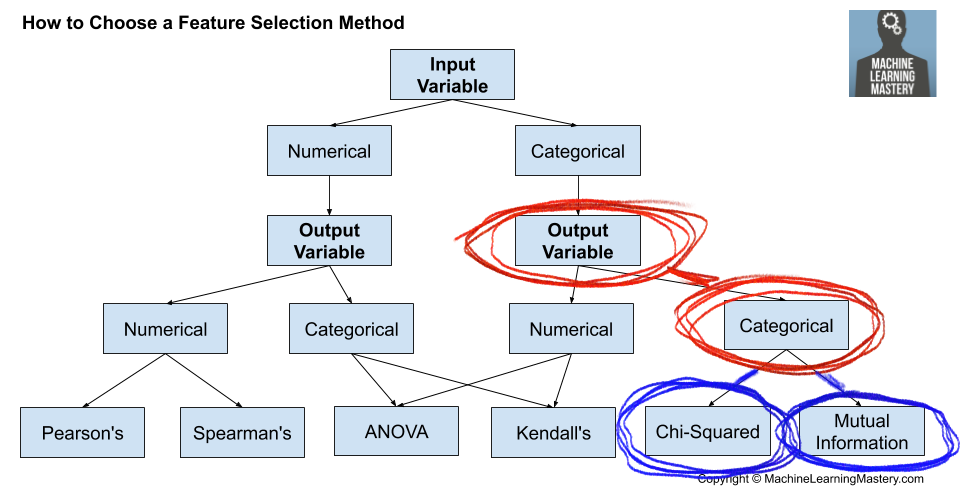

## <span style="color:blue"> Mutual Information Feature Selection: Mutual_info_classif ()

Mmutual Information is usually used in the construction of decision trees for selecting variables.

In [39]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest


def select_features_MIC(X_train, y_train, X_test):
    MIC = SelectKBest(score_func=mutual_info_classif, k='all')
    MIC.fit(X_train, y_train)
    X_train_MIC = MIC.transform(X_train)
    X_test_MIC = MIC.transform(X_test)
    return X_train_MIC, X_test_MIC, MIC

In [22]:
X_train_MIC, X_test_MIC, MIC = select_features_MIC(X_train, y_train, X_test)

In [23]:
for i in range(len(MIC.scores_)):
    r = MIC.scores_[i]
    if r>0:
        print('Feature %d: %f' % (i, MIC.scores_[i]))

Feature 0: 0.000347
Feature 1: 0.038747
Feature 2: 0.035121
Feature 3: 0.016765
Feature 4: 0.031111
Feature 5: 0.024158
Feature 6: 0.008067
Feature 7: 0.017851
Feature 8: 0.004052
Feature 9: 0.015306
Feature 10: 0.021261
Feature 11: 0.003064
Feature 12: 0.020094
Feature 13: 0.028453
Feature 14: 0.031606
Feature 15: 0.024541


In [24]:
importance_mic = np.round(MIC.scores_, decimals=3)
importance_mic

array([0.   , 0.039, 0.035, 0.017, 0.031, 0.024, 0.008, 0.018, 0.004,
       0.015, 0.021, 0.003, 0.02 , 0.028, 0.032, 0.025])

In [25]:
KOT_MIC = dict(zip(df2, importance_mic))
KOT_sorted_keys_MIC = sorted(KOT_MIC, key=KOT_MIC.get, reverse=True)

for r in KOT_sorted_keys_MIC:
    m = KOT_MIC[r]
    if m>0:
        print (r, KOT_MIC[r])   

klik 0.039
data_godzina 0.035
urz_polaczenie 0.032
strona_id 0.031
urz_typ 0.028
kat1 0.025
strona_domena 0.024
urz_id 0.021
urz_model 0.02
aplikacja_id 0.018
baner_pozycja 0.017
aplikacja_kategoria 0.015
strona_kategoria 0.008
aplikacja_domena 0.004
urz_ip 0.003


## <span style="color:blue"> Feature Selection by Chi-Squared

In [26]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

def select_features_CH2(X_train, y_train, X_test):
    CH2 = SelectKBest(score_func=chi2, k=4)
    CH2.fit(X_train, y_train)
    X_train_CH2 = CH2.transform(X_train)
    X_test_CH2 = CH2.transform(X_test)
    return X_train_CH2, X_test_CH2, CH2

In [27]:
X_train_CH2, X_test_CH2, CH2 = select_features_CH2(X_train, y_train, X_test)

In [28]:
for i in range(len(CH2.scores_)):
    r = CH2.scores_[i]
    if r>50:
        print('Feature %d: %f' % (i, CH2.scores_[i]))

Feature 0: 67.070875
Feature 1: 3293.772923
Feature 2: 32758.915490
Feature 3: 83.810820
Feature 4: 75193.107933
Feature 5: 1081.035396
Feature 6: 5639.027682
Feature 7: 11940.069704
Feature 8: 37621.181027
Feature 9: 51.080130
Feature 10: 64.326852
Feature 11: 2175.922678
Feature 14: 552.922827


## <span style="color:green"> Sprawdzenie czy dobrze przyporządkował. Trzeba porównać nazwę poniżej z nazwą po zip.

In [29]:
df2.columns[3]

'baner_pozycja'

In [30]:
importance_CH2 = np.round(CH2.scores_, decimals=3)
importance_CH2

KOT_CH2 = dict(zip(df2, importance_CH2))
KOT_CH2_sorted_keys = sorted(KOT_CH2, key=KOT_CH2.get, reverse=True)

for r in KOT_CH2_sorted_keys:
    g = KOT_CH2[r]
    if g>50:
        print (KOT_CH2[r],r)

75193.108 strona_id
37621.181 aplikacja_domena
32758.915 data_godzina
11940.07 aplikacja_id
5639.028 strona_kategoria
3293.773 klik
2175.923 urz_ip
1081.035 strona_domena
552.923 urz_polaczenie
83.811 baner_pozycja
67.071 id
64.327 urz_id
51.08 aplikacja_kategoria


## Tworzę tabelkę podsumowującą: Chi-Squared i Mutual Information

In [31]:
feature_name = X_cat.columns

feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Chi-Squared':importance_CH2, 'Mutual Information':importance_mic})
feature_selection_df["Rank_MIC"] = feature_selection_df["Mutual Information"].rank(method ='average')
feature_selection_df["Rank_CH2"] = feature_selection_df["Chi-Squared"].rank(method ='average') 
feature_selection_df

del feature_selection_df['Chi-Squared'] 
del feature_selection_df['Mutual Information'] 

feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
feature_selection_df = feature_selection_df.sort_values('Total',ascending=False )
feature_selection_df.head(20)

,Feature,Rank_MIC,Rank_CH2,Total
2,strona_domena,15.0,14.0,29.0
4,aplikacja_id,13.0,16.0,29.0
1,strona_id,16.0,11.0,27.0
14,kat4,14.0,8.0,22.0
7,urz_id,7.0,13.0,20.0
5,aplikacja_domena,10.0,9.0,19.0
8,urz_ip,3.0,15.0,18.0
6,aplikacja_kategoria,4.0,12.0,16.0
10,urz_typ,9.0,5.0,14.0
13,kat3,12.0,2.0,14.0


Sprawdzam liczebność zbioru:

In [32]:
feature_selection_df.shape ##<-- wyszła jedna zmienna 'Target'

(16, 4)

# Feature Selection Techniques (by filter methods): numerical_ input, categorical output

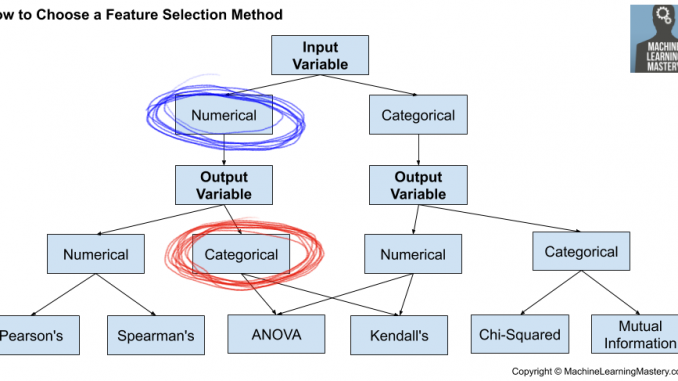

### <span style="color:purple"> Wydzielam zmienne numeryczne

Muszę dodać zmienną kategoryczną 'TARGET' bo jest to zmienna wynikowa (mimo, że jest to zmienna dyskretna).

In [33]:
num_c = df2.columns[numerical_fun]

df_num= df2[num_c]

df_num[result] = df2[result]
df_num.head(3)

,id,data_godzina,kat2,kat5,kat7,kat8,kat9,klik
2912077,93718246916792680,17030810,117239,11973,10039,0,23,0
354809,93718246914235412,17030118,116615,11863,10039,0,23,0
2979730,93718246916860333,17030813,123224,12676,10035,100177,221,0


In [34]:
X_num = df_num.drop(result, axis=1)
y = df_num[result]

## Redukcja zmiennych niezależnych za pomocą OLS

In [35]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

model = sm.OLS(y, sm.add_constant(X_num))
model_fit = model.fit()

print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                   klik   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     334.0
Date:                Fri, 17 Apr 2020   Prob (F-statistic):          5.96e-287
Time:                        21:08:48   Log-Likelihood:                -78857.
No. Observations:              180981   AIC:                         1.577e+05
Df Residuals:                  180976   BIC:                         1.578e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.674e-19   1.38e-19     -1.209   

Wyodrębniam z powyższego zestawienia tabelę z 'P>|t|'

In [36]:
p_values = model_fit.summary2().tables[1]['P>|t|']

Obrabiam tą tabelę, zaokrąglam itp.

In [37]:
p_values = np.round(p_values, decimals=2)
p_values= p_values.sort_values(ascending=True)

p_values = p_values.to_frame()
print(p_values.shape)

p_values[p_values['P>|t|']<=0.01]   #<--wartości p-value mniejsze i równe 0.01

(8, 1)


,P>|t|
kat2,0.00
kat8,0.00
kat5,0.01
kat9,0.01


Dodaje ranking ważności (odwrotny - najlepsze są te gdzie p-value<0.01).

In [38]:
p_values.drop('const', axis=0, inplace=True)

In [39]:
p_values["p-value_rank"] = p_values["P>|t|"].rank(method ='min',ascending=False) 
p_values.head(5)

,P>|t|,p-value_rank
kat2,0.00,6.0
kat8,0.00,6.0
kat5,0.01,4.0
kat9,0.01,4.0
data_godzina,0.24,3.0


Mnożę razy dwa ponieważ dla zmiennych kategorycznych mam dwa testy a dla zmiennych numerycznych mam jeden test. Chodzi o wyrównanie szans.

In [40]:
del p_values['P>|t|'] 
p_values['p-value_x2'] = p_values['p-value_rank']*2
del p_values['p-value_rank'] 
p_values.head(3)

,p-value_x2
kat2,12.0
kat8,12.0
kat5,8.0


In [41]:
feature_selection_df=feature_selection_df.set_index('Feature')

In [42]:
del feature_selection_df['Total']

In [43]:
feature_selection_df.shape

(16, 2)

In [44]:
p_values.shape

(7, 1)

In [45]:
df6 = pd.concat([p_values,feature_selection_df], sort=True)
df6

,Rank_CH2,Rank_MIC,p-value_x2
kat2,NaN,NaN,12.0
kat8,NaN,NaN,12.0
kat5,NaN,NaN,8.0
kat9,NaN,NaN,8.0
data_godzina,NaN,NaN,6.0
id,NaN,NaN,4.0
kat7,NaN,NaN,2.0
strona_domena,14.0,15.0,NaN
aplikacja_id,16.0,13.0,NaN
strona_id,11.0,16.0,NaN


In [46]:
print('columns: ',df6.columns)
print(df6.shape)

columns:  Index(['Rank_CH2', 'Rank_MIC', 'p-value_x2'], dtype='object')
(23, 3)


# <span style="color:red"> Wrapper Method

### Feature Selection Techniques – Backward Elimination

In [47]:
X = df2.drop(result, axis=1) 
y = df2[result]  

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)
# Jeżeli się rzuca wtedy wycinamy stratify=y.

# Recursive Feature Elimination (RFE)

Ustawiam liczbę zmiennych, które pozostaną w modelu

In [48]:
Num_v  =  15

In [49]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

model=LinearRegression()
rfe=RFE(model,Num_v)

# Standaryzacja zmiennych

X_rfe = rfe.fit_transform(X,y)

model.fit(X_rfe,y)

print('Number of selected functions:  ',rfe.n_features_)
print()
print('The mask of selected features: ',rfe.support_)
print()
print('The feature ranking:',rfe.ranking_)
print()
print('The external estimator:',rfe.estimator_)

Number of selected functions:   15

The mask of selected features:  [False False  True False  True  True  True  True  True False False False
  True  True  True  True  True  True  True  True False False  True]

The feature ranking: [8 5 1 3 1 1 1 1 1 7 9 4 1 1 1 1 1 1 1 1 2 6 1]

The external estimator: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


#### Metoda zip na wyświetlenie rankingu cech

In [50]:
PPS = rfe.ranking_

KOT_MIC = dict(zip(df, PPS))
KOT_sorted_keys_MIC = sorted(KOT_MIC, key=KOT_MIC.get, reverse=True)

for r in KOT_sorted_keys_MIC:
    print (r, KOT_MIC[r])

urz_id 9
id 8
aplikacja_kategoria 7
kat7 6
klik 5
urz_ip 4
baner_pozycja 3
kat6 2
data_godzina 1
strona_id 1
strona_domena 1
strona_kategoria 1
aplikacja_id 1
aplikacja_domena 1
urz_model 1
urz_typ 1
urz_polaczenie 1
kat1 1
kat2 1
kat3 1
kat4 1
kat5 1
kat8 1


## Embedded Method (Lasso)

In [51]:
Num_v = 15

In [52]:
from sklearn import linear_model

#rlasso = RandomizedLasso(alpha=0.025)

# Standaryzacja zmiennych

lasso = linear_model.Lasso(alpha=0.1, positive=True)
lasso.fit(X, y)


#print(lasso.coef_)
#print()
#print(lasso.intercept_)
#print()
#print(lasso.score(X,y))

lasso = lasso.coef_

Metoda zip na wyświetlenie ocen cechy

In [53]:
PPS = lasso

#PPS = np.round(PPS, decimals=8)

KOT_lasso = dict(zip(df, PPS))
KOT_sorted_keys_lasso = sorted(KOT_lasso, key=KOT_lasso.get, reverse=True)


for r in KOT_sorted_keys_lasso:
    print (r, (KOT_lasso[r]))

kat3 0.000958768830648506
strona_kategoria 5.67871132873995e-05
kat6 1.2537216493178487e-05
urz_ip 8.990563068087638e-07
id 0.0
klik 0.0
data_godzina 0.0
baner_pozycja 0.0
strona_id 0.0
strona_domena 0.0
aplikacja_id 0.0
aplikacja_domena 0.0
aplikacja_kategoria 0.0
urz_id 0.0
urz_model 0.0
urz_typ 0.0
urz_polaczenie 0.0
kat1 0.0
kat2 0.0
kat4 0.0
kat5 0.0
kat7 0.0
kat8 0.0


## RandomForestClassifier

In [54]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [55]:
importance_RFC = rfc.feature_importances_

In [56]:
importance_RFC = np.round(importance_RFC, decimals=3)
importance_RFC

array([0.   , 0.185, 0.006, 0.034, 0.03 , 0.011, 0.016, 0.007, 0.006,
       0.034, 0.276, 0.184, 0.002, 0.01 , 0.003, 0.076, 0.008, 0.009,
       0.023, 0.006, 0.015, 0.043, 0.017])

In [57]:
KOT = dict(zip(X, importance_RFC))
KOT_sorted_keys = sorted(KOT, key=KOT.get, reverse=True)

for r in KOT_sorted_keys:
    print (r, KOT[r])

    KOT

urz_ip 0.276
data_godzina 0.185
urz_model 0.184
kat2 0.076
kat8 0.043
strona_id 0.034
urz_id 0.034
strona_domena 0.03
kat5 0.023
kat9 0.017
aplikacja_id 0.016
kat7 0.015
strona_kategoria 0.011
urz_polaczenie 0.01
kat4 0.009
kat3 0.008
aplikacja_domena 0.007
baner_pozycja 0.006
aplikacja_kategoria 0.006
kat6 0.006
kat1 0.003
urz_typ 0.002
id 0.0


# Zestawienie informacji z modeli
Sprawdzenie wymiarów:

In [58]:
feature_name = X.columns
print('feature_name:                      ',feature_name.shape)
print('RandomForestClassifier_RFC:        ',importance_RFC.shape)
print('Recursive Feature Elimination_RFE: ',rfe.ranking_.shape)
print('lasso:                             ',lasso.shape)


feature_name:                       (23,)
RandomForestClassifier_RFC:         (23,)
Recursive Feature Elimination_RFE:  (23,)
lasso:                              (23,)


## Tworzymy tabelę porównawczą modeli:

In [59]:
feat_sel_df = pd.DataFrame({'Feature':feature_name, 'RandomForestClassifier':importance_RFC, 'Recursive Feature Elimination (RFE)':rfe.ranking_,'lasso':lasso})

In [60]:
feat_sel_df.head(3)

,Feature,RandomForestClassifier,Recursive Feature Elimination (RFE),lasso
0,id,0.000,8,0.0
1,data_godzina,0.185,5,0.0
2,baner_pozycja,0.006,1,0.0


Jak widać oceny są niekompatibilne do siebie dlatego zrobiłem ocenę rankingową

### Tworzymy tabelę rankingową dla Wrapper Method

In [61]:
feat_sel_df["RFC"] = feat_sel_df["RandomForestClassifier"].rank(method ='average')
feat_sel_df["RFE"] = feat_sel_df["Recursive Feature Elimination (RFE)"].rank(method ='average')
feat_sel_df["Lasso"] = feat_sel_df["lasso"].rank(method ='average')

del feat_sel_df['RandomForestClassifier'] 
del feat_sel_df['Recursive Feature Elimination (RFE)'] 
del feat_sel_df['lasso'] 

In [62]:
feat_sel_df['Total'] = feat_sel_df['RFC']+feat_sel_df['RFE']+feat_sel_df['Lasso']
feat_sel_df = feat_sel_df.sort_values('Total',ascending=False )
feat_sel_df.head(10)

,Feature,RFC,RFE,Lasso,Total
11,urz_model,21.0,18.0,20.0,59.0
10,urz_ip,23.0,23.0,10.0,56.0
1,data_godzina,22.0,19.0,10.0,51.0
21,kat8,19.0,20.0,10.0,49.0
20,kat7,12.0,16.0,21.0,49.0
9,urz_id,17.5,21.0,10.0,48.5
3,strona_id,17.5,17.0,10.0,44.5
6,aplikacja_id,13.0,8.0,22.0,43.0
17,kat4,9.0,8.0,23.0,40.0
15,kat2,20.0,8.0,10.0,38.0


In [63]:
del feat_sel_df['Total']  # <- usuwam podsumowanie 'Total'

#### Ustawiamy indeks 'Feature' w tabeli Filtrów

In [64]:
print(df6.shape)   ## obie tabele filtrów i modeli muszą mieć tyle samo wierszy!
print(df6.index)
df6.reset_index()

(23, 3)
Index(['kat2', 'kat8', 'kat5', 'kat9', 'data_godzina', 'id', 'kat7',
       'strona_domena', 'aplikacja_id', 'strona_id', 'kat4', 'urz_id',
       'aplikacja_domena', 'urz_ip', 'aplikacja_kategoria', 'urz_typ', 'kat3',
       'kat6', 'strona_kategoria', 'urz_polaczenie', 'urz_model', 'kat1',
       'baner_pozycja'],
      dtype='object')


,index,Rank_CH2,Rank_MIC,p-value_x2
0,kat2,NaN,NaN,12.0
1,kat8,NaN,NaN,12.0
2,kat5,NaN,NaN,8.0
3,kat9,NaN,NaN,8.0
4,data_godzina,NaN,NaN,6.0
5,id,NaN,NaN,4.0
6,kat7,NaN,NaN,2.0
7,strona_domena,14.0,15.0,NaN
8,aplikacja_id,16.0,13.0,NaN
9,strona_id,11.0,16.0,NaN


#### Ustawiamy indeks 'Feature' w tabeli Wrapper Method (kolanem dopychamy)

In [65]:
feat_sel_df.reset_index()
feat_sel_df= feat_sel_df.set_index('Feature')
print(feat_sel_df.shape)
print(feat_sel_df.index)
print(feat_sel_df.columns)

(23, 3)
Index(['urz_model', 'urz_ip', 'data_godzina', 'kat8', 'kat7', 'urz_id',
       'strona_id', 'aplikacja_id', 'kat4', 'kat2', 'strona_domena', 'kat5',
       'id', 'kat9', 'strona_kategoria', 'urz_polaczenie', 'kat3',
       'aplikacja_domena', 'aplikacja_kategoria', 'kat6', 'baner_pozycja',
       'kat1', 'urz_typ'],
      dtype='object', name='Feature')
Index(['RFC', 'RFE', 'Lasso'], dtype='object')


### Tworzenie wspólnej tabeli Filters + Wrapper Method

In [66]:
NOWA = pd.merge(feat_sel_df,df6, how='inner', left_index=True, right_index=True)

NOWA['Total'] = np.sum(NOWA, axis=1)
NOWA = NOWA.sort_values('Total',ascending=False )
NOWA.head(20)

,RFC,RFE,Lasso,Rank_CH2,Rank_MIC,p-value_x2,Total
urz_ip,23.0,23.0,10.0,15.0,3.0,NaN,74.0
aplikacja_id,13.0,8.0,22.0,16.0,13.0,NaN,72.0
strona_id,17.5,17.0,10.0,11.0,16.0,NaN,71.5
urz_id,17.5,21.0,10.0,13.0,7.0,NaN,68.5
urz_model,21.0,18.0,20.0,4.0,5.0,NaN,68.0
strona_domena,16.0,8.0,10.0,14.0,15.0,NaN,63.0
kat4,9.0,8.0,23.0,8.0,14.0,NaN,62.0
kat8,19.0,20.0,10.0,NaN,NaN,12.0,61.0
data_godzina,22.0,19.0,10.0,NaN,NaN,6.0,57.0
kat7,12.0,16.0,21.0,NaN,NaN,2.0,51.0
